In [1]:
from __future__ import print_function

import os
import datetime
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import tensorflow as tf
# for reproducibility
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.datasets import cifar10
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten,Convolution2D, MaxPooling2D,ZeroPadding2D,AveragePooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.initializers import he_normal 
from keras.layers.normalization import BatchNormalization
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD,Adam
from keras import optimizers

from sklearn.datasets import make_classification
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import pandas as pd
import cv2

In [3]:
def load_data(train_path):
    x_train_list=[]
    y_train_list=[]
    
    data_dir = os.walk(train_path)
    for root, dirs, files in data_dir:
        if dirs==[] and files!=[]:
            for f in files:
                x_train_list.append(os.path.join(root, f))
                y_train_list.append(root.split("/")[-1])
                
    return x_train_list, y_train_list

In [4]:
train_path = "datasets/train"

In [5]:
classes_list = {'abnormal':0, 'normal':1}

x_train_list, y_train_list = load_data(train_path)
        
s = pd.DataFrame(y_train_list,columns = ["name"])
s["name"] = s["name"].map(classes_list)

y_train = np.array(s["name"])


x_train = []
for i,each in enumerate(x_train_list):
    try:
        img = cv2.imread(each)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(img)
        x_train.append(img)
    except:
        y_train = np.delete(y_train,i)
        continue
    
x_train = np.array(x_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


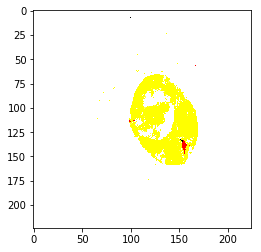

In [10]:
len(y_train)
plt.imshow(x_train[888], cmap='gray')

In [8]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


X_train, X_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.05, stratify = y_train)


X_train, y_train = shuffle(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
Y_train = np.eye(2)[y_train]
Y_valid = np.eye(2)[y_valid]

In [ ]:
batch_size = 32
nb_classes = 5
nb_epoch = 50

# input image dimensions
img_width, img_height = 224,224

In [10]:
print(X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)

(883, 224, 224, 3) (883, 2) (47, 224, 224, 3) (47, 2)


In [11]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

for i in range(3):
    X_train[:,:,:,i]= X_train[:,:,:,i]

    X_valid[:,:,:,i]= X_valid[:,:,:,i]


print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')

X_train shape: (883, 224, 224, 3)
883 train samples


In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        fill_mode = "constant",
        zoom_range = 1,
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [13]:
base_model = ResNet50( weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Flatten()(x)
#x = Dense(256, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)
#x = Dense(512, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)
#x = Dense(64, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.4)(x)


# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

#for i,layer in enumerate(base_model.layers):
#    layer.trainable = False

model.compile(optimizer=Adam(lr=10e-6), loss='categorical_crossentropy',metrics=['accuracy'])
#model.fit(X_train,Y_train,epochs=25,batch_size=batch_size)
#datagen.flow(X_train,Y_train,batch_size=batch_size),

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


callbacks=callbacks_list

In [14]:
history=model.fit_generator(datagen.flow(X_train,Y_train,batch_size=batch_size),
                            samples_per_epoch=X_train.shape[0],nb_epoch=nb_epoch,verbose=1,validation_data=(X_valid, Y_valid))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., verbose=1, validation_data=(array([[[..., steps_per_epoch=27, epochs=50)`
  


Epoch 1/50
27/27 [==============================] - 17s 627ms/step - loss: 0.5401 - acc: 0.7356 - val_loss: 0.2057 - val_acc: 0.9362
Epoch 2/50
27/27 [==============================] - 7s 253ms/step - loss: 0.2703 - acc: 0.9097 - val_loss: 0.0898 - val_acc: 0.9787
Epoch 3/50
27/27 [==============================] - 7s 247ms/step - loss: 0.1758 - acc: 0.9467 - val_loss: 0.0634 - val_acc: 0.9787
Epoch 4/50
27/27 [==============================] - 7s 250ms/step - loss: 0.1387 - acc: 0.9629 - val_loss: 0.0451 - val_acc: 0.9787
Epoch 5/50
27/27 [==============================] - 7s 248ms/step - loss: 0.1119 - acc: 0.9583 - val_loss: 0.0355 - val_acc: 0.9787
Epoch 6/50
27/27 [==============================] - 7s 250ms/step - loss: 0.0954 - acc: 0.9680 - val_loss: 0.0292 - val_acc: 0.9787
Epoch 7/50
27/27 [==============================] - 7s 251ms/step - loss: 0.0828 - acc: 0.9691 - val_loss: 0.0207 - val_acc: 1.0000
Epoch 8/50
27/27 [==============================] - 7s 249ms/step - loss: 0

In [15]:
weight_name='model_weight_with_ResNet50.h5'
model.save(weight_name)

In [38]:
test_path = "datasets/test"

x_test_list, y_test_list = load_data(test_path)
        
s = pd.DataFrame(y_test_list,columns = ["name"])
s["name"] = s["name"].map(classes_list)

y_test = np.array(s["name"])


X_test = []
for i,each in enumerate(x_test_list):
    try:
        img = cv2.imread(each)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(img)
        X_test.append(img)
    except:
        y_test = np.delete(y_test,i)
        continue
        
X_test = np.array(X_test)
Y_test = np.eye(2)[y_test]
result=model.predict(X_test, verbose=0, steps=None)
scores = model.evaluate(X_test[:,:,:,:], Y_test[:,:], verbose=0)
print(scores[0],scores[1])
print(pd.crosstab(np.array(y_test), np.array(np.argmax(result, axis=1)),
                      rownames=['label'], colnames=['predict']))
print(classification_report(np.array(y_test), np.array(np.argmax(result, axis=1))))    

<generator object walk at 0x7fd4a4d29db0>
datasets/test/abnormal
[]
496
<generator object walk at 0x7fd4a4d29db0>
datasets/test/normal
[]
229
2.71088592463 0.529737206086
predict    0    1
label            
0        157  338
1          2  226
             precision    recall  f1-score   support

          0       0.99      0.32      0.48       495
          1       0.40      0.99      0.57       228

avg / total       0.80      0.53      0.51       723



In [50]:
test_path = "datasets/test2"

x_test_list, y_test_list = load_data(test_path)
        
s = pd.DataFrame(y_test_list,columns = ["name"])
s["name"] = s["name"].map(classes_list)

y_test = np.array(s["name"])

X_test = []
for i,each in enumerate(x_test_list):
    try:
        img = cv2.imread(each)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(img)
        X_test.append(img)
    except:
        y_test = np.delete(y_test,i)
        continue

X_test = np.array(X_test)
Y_test = np.eye(2)[y_test]
scores = model.evaluate(X_test, Y_test, verbose=0)
result=model.predict(X_test, verbose=0, steps=None)
print(scores[0],scores[1])
print(pd.crosstab(np.array(y_test), np.array(np.argmax(result, axis=1)),
                      rownames=['label'], colnames=['predict']))
print(classification_report(np.array(y_test), np.array(np.argmax(result, axis=1))))    

0.18623457192 0.94
predict   0   1
label          
0        50   0
1         6  44
             precision    recall  f1-score   support

          0       0.89      1.00      0.94        50
          1       1.00      0.88      0.94        50

avg / total       0.95      0.94      0.94       100

